In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("Close.csv")

In [2]:
df2 = pd.read_csv('Date.csv', parse_dates=['AA'])

C:\Users\New User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,2

In [3]:
Date = df2['AA']

In [4]:
stock = 'AAPL'


def create_time_series(symbol):
    ts = pd.Series(df[symbol].values, index=Date)
    return ts[ts.first_valid_index():]

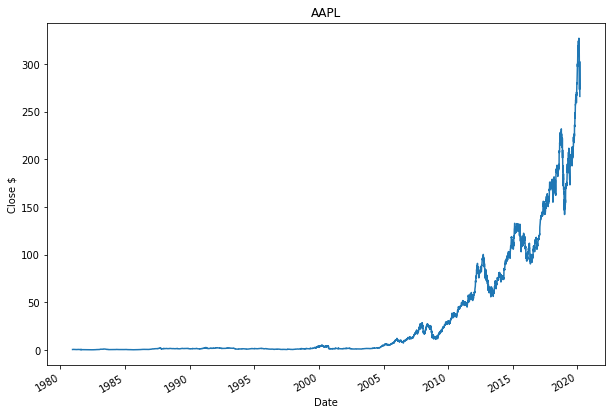

In [5]:
ts = create_time_series(stock)
ts.plot(figsize=(10, 7))
plt.xlabel('Date')
plt.ylabel('Close $')
plt.title(stock)
plt.show()

In [6]:
ts[:-20]

AA
1980-12-12      0.513393
1980-12-15      0.486607
1980-12-16      0.450893
1980-12-17      0.462054
1980-12-18      0.475446
                 ...    
2020-02-03    308.660004
2020-02-04    318.850006
2020-02-05    321.450012
2020-02-06    325.209991
2020-02-07    320.029999
Length: 9873, dtype: float64

# LSTM

In [7]:
import tensorflow
print(tensorflow.__version__)

2.1.0


In [8]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [9]:
# Some functions to help out with
def plot_predictions(test, predicted):
    plt.plot(test, color='red', label='Real AAPL Stock Price')
    plt.plot(predicted, color='blue', label='Predicted AAPL Stock Price')
    plt.xlabel('Days')
    plt.legend()


def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [10]:
ts.shape

(9893,)

In [11]:
ts

AA
1980-12-12      0.513393
1980-12-15      0.486607
1980-12-16      0.450893
1980-12-17      0.462054
1980-12-18      0.475446
                 ...    
2020-03-03    289.320007
2020-03-04    302.739990
2020-03-05    292.920013
2020-03-06    289.029999
2020-03-09    266.170013
Length: 9893, dtype: float64

In [12]:
# Checking for missing values
training_set = ts['2006':'2018'].values
test_set = ts['2019':].values

In [13]:
training_set.shape

(3271,)

In [14]:
test_set.shape

(298,)

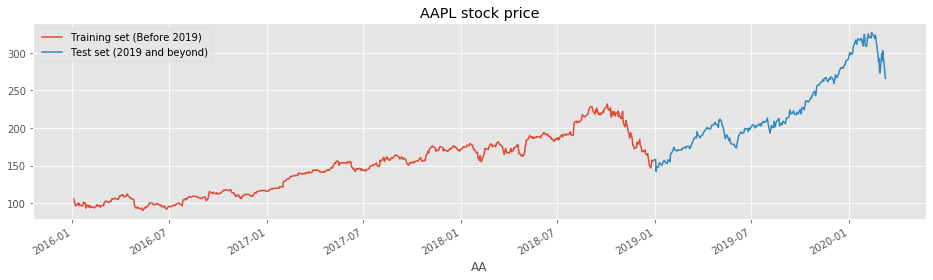

In [15]:
# We have chosen 'Close' attribute for prices. Let's see what it looks like
ts['2016':'2018'].plot(figsize=(16, 4), legend=True)
ts['2019':].plot(figsize=(16, 4), legend=True)
plt.legend(['Training set (Before 2019)', 'Test set (2019 and beyond)'])
plt.title('AAPL stock price')
plt.savefig('AAPLstockLSTM.png')
plt.show()

In [16]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set.reshape(-1, 1))
training_set_scaled

array([[0.01530035],
       [0.01544014],
       [0.01506525],
       ...,
       [0.66232474],
       [0.66268057],
       [0.66939676]])

In [17]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements
X_train = []
y_train = []
for i in range(60, 3271):
    X_train.append(training_set_scaled[i - 60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [18]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [19]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop', loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train, y_train, epochs=30, batch_size=32)

Train on 3211 samples
Epoch 1/30
3211/3211 [==============================] - 40s 12ms/sample - loss: 0.0105
Epoch 2/30
3211/3211 [==============================] - 20s 6ms/sample - loss: 0.0041
Epoch 3/30
3211/3211 [==============================] - 20s 6ms/sample - loss: 0.0033
Epoch 4/30
3211/3211 [==============================] - 18s 6ms/sample - loss: 0.0031
Epoch 5/30
3211/3211 [==============================] - 22s 7ms/sample - loss: 0.0025
Epoch 6/30
3211/3211 [==============================] - 20s 6ms/sample - loss: 0.0022
Epoch 7/30
3211/3211 [==============================] - 20s 6ms/sample - loss: 0.0021
Epoch 8/30
3211/3211 [==============================] - 19s 6ms/sample - loss: 0.0020
Epoch 9/30
3211/3211 [==============================] - 19s 6ms/sample - loss: 0.0019
Epoch 10/30
3211/3211 [==============================] - 19s 6ms/sample - loss: 0.0017
Epoch 11/30
3211/3211 [==============================] - 19s 6ms/sample - loss: 0.0016
Epoch 12/30
3211/3211 [======

In [20]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole
# 'High' attribute data for processing
dataset_total = pd.concat((ts['2006':'2018'], ts['2019':]), axis=0)
inputs = dataset_total[len(dataset_total) - len(test_set) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

In [21]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60, 358):
    X_test.append(inputs[i - 60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [22]:
X_test.shape

(298, 60, 1)

In [23]:
test_set.shape

(298,)

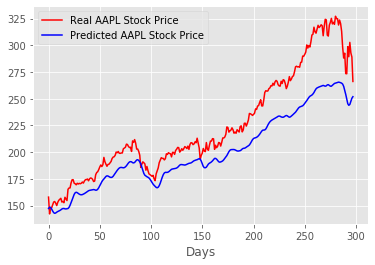

In [24]:
# Visualizing the results for LSTM
plot_predictions(test_set, predicted_stock_price)
plt.savefig('LSTM_prediction_AAPL.png')

In [25]:
# Evaluating our model
return_rmse(test_set, predicted_stock_price)

The root mean squared error is 27.834107178765265.
